In [2]:
import sys, csv
from essentia import *
from essentia.standard import *
from pylab import *
from numpy import *
import matplotlib.pyplot as plt
import numpy as np

import librosa
import librosa.display

In [3]:
filename = 'flamenco.wav'

hopSize = 128
frameSize = 2048
sampleRate = 44100
guessUnvoiced = True

## Melody Extraction Step by Step

In [4]:
run_windowing = Windowing(type='hann', zeroPadding=3*frameSize) # Hann window with x4 zero padding
run_spectrum = Spectrum(size=frameSize * 4)
run_spectral_peaks = SpectralPeaks(minFrequency=1,
                                   maxFrequency=20000,
                                   maxPeaks=100,
                                   sampleRate=sampleRate,
                                   magnitudeThreshold=0,
                                   orderBy="magnitude")
run_pitch_salience_function = PitchSalienceFunction()
run_pitch_salience_function_peaks = PitchSalienceFunctionPeaks()
run_pitch_contours = PitchContours(hopSize=hopSize)
run_pitch_contours_melody = PitchContoursMelody(guessUnvoiced=guessUnvoiced,
                                                hopSize=hopSize)

# ... and create a Pool
pool = Pool();

# Now we are ready to start processing.
# 1. Load audio and pass it through the equal-loudness filter
audio = MonoLoader(filename=filename)()
audio = EqualLoudness()(audio)

# 2. Cut audio into frames and compute for each frame:
#    spectrum -> spectral peaks -> pitch salience function -> pitch salience function peaks
for frame in FrameGenerator(audio, frameSize=frameSize, hopSize=hopSize):
    frame = run_windowing(frame)
    spectrum = run_spectrum(frame)
    peak_frequencies, peak_magnitudes = run_spectral_peaks(spectrum)
    
    salience = run_pitch_salience_function(peak_frequencies, peak_magnitudes)
    salience_peaks_bins, salience_peaks_saliences = run_pitch_salience_function_peaks(salience)
    
    pool.add('allframes_salience_peaks_bins', salience_peaks_bins)
    pool.add('allframes_salience_peaks_saliences', salience_peaks_saliences)

# 3. Now, as we have gathered the required per-frame data, we can feed it to the contour 
#    tracking and melody detection algorithms:
contours_bins, contours_saliences, contours_start_times, duration = run_pitch_contours(
        pool['allframes_salience_peaks_bins'],
        pool['allframes_salience_peaks_saliences'])
pitch, confidence = run_pitch_contours_melody(contours_bins,
                                              contours_saliences,
                                              contours_start_times,
                                              duration)

In [5]:
print(pitch)

[  0.        0.        0.      ... 198.2766  198.2766  195.99919]


number of frames: 4904


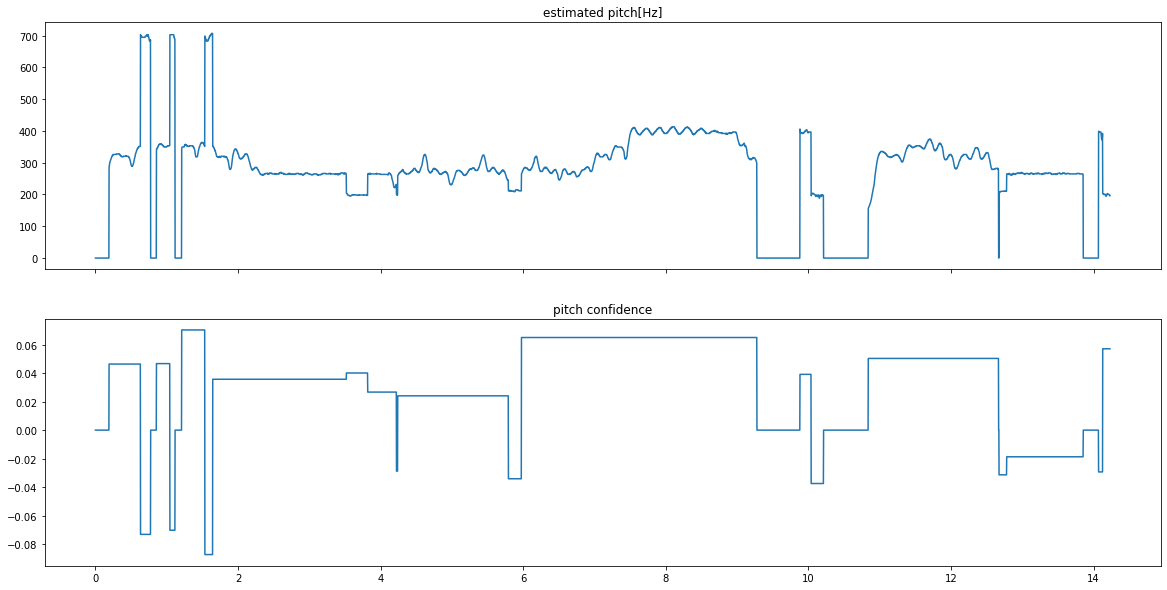

In [6]:
n_frames = len(pitch)
print("number of frames: %d" % n_frames)
time=np.linspace(0.0,len(audio)/44100.0,len(pitch) )

# visualize output pitch
# plot the pitch contour and confidence over time
f, axarr = plt.subplots(2, sharex=True, figsize=(20, 10))
axarr[0].plot(time,pitch)
axarr[0].set_title('estimated pitch[Hz]')
axarr[1].plot(time,confidence)
axarr[1].set_title('pitch confidence')
plt.show()


## Using Predominant Picth Melody

In [7]:
# create an audio loader and import audio file
loader = essentia.standard.MonoLoader(filename = filename, sampleRate = sampleRate)
audio = loader()
print("Duration of the audio sample [sec]:")
print(len(audio)/sampleRate)

Duration of the audio sample [sec]:
14.22859410430839


## Função de Melodia

In [184]:
def melody_extraction(audio, framesize, hopsize):
    # PitchMelodia takes the entire audio signal as input - no frame-wise processing is required here...
    pExt = PredominantPitchMelodia(frameSize = framesize, hopSize = hopsize)
    pitch, pitchConf = pExt(audio)
    time=np.linspace(0.0,len(audio)/sampleRate,len(pitch) )
    
    return pitch, pitchConf, time

## Conversões

In [185]:
def hz_to_cents(hz, fref=440.0):
    m = np.asanyarray(hz)/fref
    return 1200*(np.log2(m, out=np.zeros_like(m), where=(m!=0.))) # - np.log2(fref))

def cents_to_hz(cents, fref=440.0):
    return fref * 2**(np.asanyarray(cents)/1200)

def hz_to_idx_semitone(hz, fref=440.0, pcpsize=12.0):
    return np.round(pcpsize*(np.log2(np.asanyarray(hz))- np.log2(fref))) % pcpsize + 1

def semitone_dist_to_hz(semitone, fref=440.0, pcpsize=12):
    return fref * 2**(np.asanyarray(semitone)/pcpsize)

def hz_to_octs(hz, tuning=0.0, pcpsize=12, fref=440.0):
    A440 = fref * 2.0 ** (tuning / pcpsize-4)
    return np.log2(np.asanyarray(hz) / float(A440))

def octs_to_hz(octs, tuning=0.0, pcpsize=12, fref=440.0):
    A440 = fref * 2.0 ** (tuning / pcpsize-4)
    return float(A440) * (2.0 ** np.asanyarray(octs))

def midi_to_hz(p):
    return 440.0 * (2.0 ** ((np.asanyarray(p) - 69.0) / 12.0))

def hz_to_midi(hz):
    return 12 * (np.log2(np.asanyarray(hz)) - np.log2(440.0)) + 69

In [186]:
pitch, pitchConf, time = melody_extraction(audio, frameSize, hopSize)

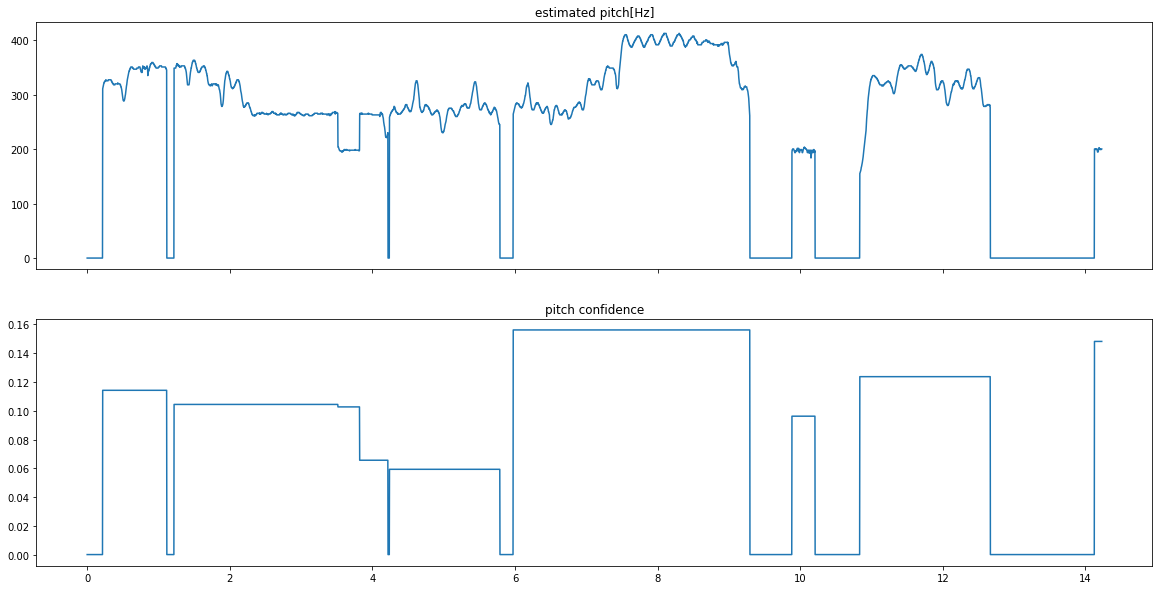

In [187]:
# plot the pitch contour and confidence over time
f, axarr = plt.subplots(2, sharex=True, figsize=(20, 10))
axarr[0].plot(time,pitch)
axarr[0].set_title('estimated pitch[Hz]')
axarr[1].plot(time,pitchConf)
axarr[1].set_title('pitch confidence')
plt.show()

## Conversão para Cents

In [188]:
pitch_cents = hz_to_cents(pitch, fref=55.0)
print(pitch)


[  0.        0.        0.      ... 200.58047 200.58047 200.58047]


## Criação do bins para quantização

In [189]:
def quantization_semitone(pitch_cents):
    
    freqs=np.arange(-0.5,76,1)
    semitones=semitone_dist_to_hz(freqs,fref=55.0)
    bins_cents=hz_to_cents(semitones, fref=55.0)

    idx = np.digitize(pitch_cents, bins=bins_cents)
    cents_q = (bins_cents[idx]+bins_cents[idx-1])/2
    cents_q[cents_q < 1.0]  = 0.0

    return cents_q

## Quantização dos cents para semitons

In [190]:
cents_q = quantization_semitone(pitch_cents)


## Median Filter

In [191]:
import scipy
cents_q_filtered=scipy.signal.medfilt(cents_q,21)

## semitones em cents quantizados para indices das oitavas

In [192]:
def semitone_to_octave(cents, pitchConf):
    
    semitones_q = np.zeros_like(cents)
    chromagram = np.zeros((12, len(cents)))

    for i in range(len(cents)):
        if cents[i] > 1.0:
            semitones_q[i] = (cents[i] / 100) % 12
            chromagram[int(semitones_q[i]),i] = pitchConf[i]
            
    return semitones_q, chromagram

In [193]:

semitones_q, chromagram = semitone_to_octave(cents_q_filtered, pitchConf)
    
    
semitones_hz_q = cents_to_hz(cents_q_filtered, fref=55.0)
idx_octave = hz_to_idx_semitone(semitones_hz_q, fref=55.0, pcpsize=12.0)
print(cents_q_filtered)
print(semitones_q)
print(idx_octave)

[   0.    0.    0. ... 2200. 2200. 2200.]
[ 0.  0.  0. ... 10. 10. 10.]
[ 1.  1.  1. ... 11. 11. 11.]


## Reduction Chromagram

In [196]:

def chromagram_reduction(chromagram, block, time=None):
    
    nframes = int(np.ceil(chromagram.shape[1]/block))

    chromagram_reduced = np.zeros((chromagram.shape[0],nframes))
    
    time_reduced = None
    if time is not None:
        time_reduced = np.zeros((nframes,))

    for k in range(chromagram_reduced.shape[1]):
        start = k*block
        end = min((k+1)*block,chromagram.shape[1])
        chromagram_reduced[:,k] =  np.sum(chromagram[:,start:end], axis=1)
        if time is not None:
            time_reduced[k] = np.mean(time[start:end])
            
    return chromagram_reduced, time_reduced

In [197]:
block = 150

chromagram_reduced, time_reduced = chromagram_reduction(chromagram, block, time=time)

print(chromagram_reduced.shape)

(12, 33)


## plot hz quantizados

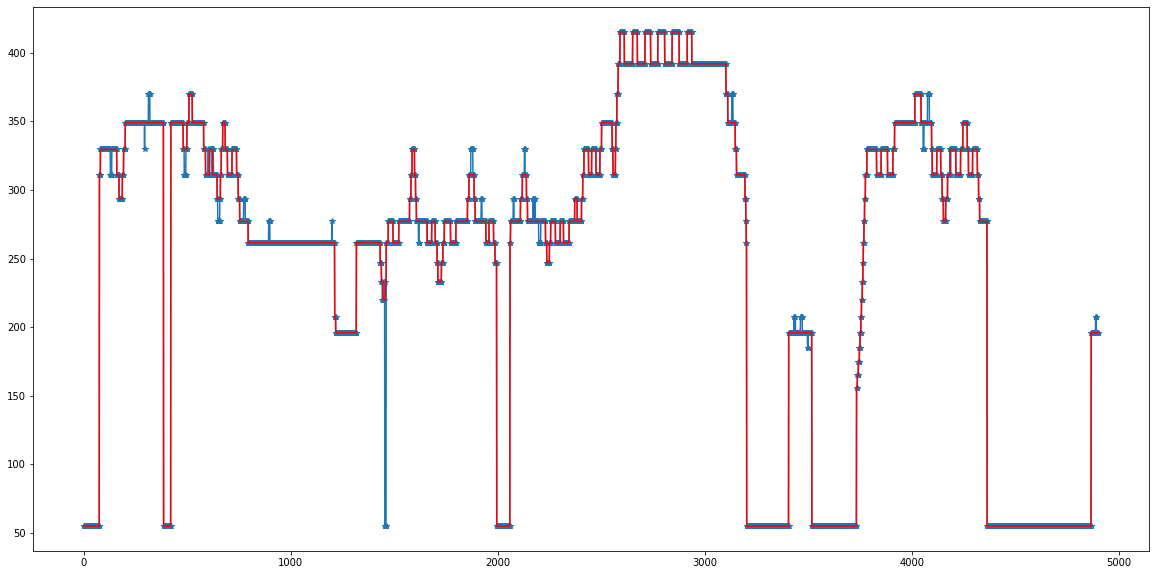

In [198]:
plt.figure(figsize=(20,10))
plt.plot(cents_to_hz(cents_q, fref=55.0),"*-")
plt.plot(cents_to_hz(cents_q_filtered, fref=55.0),"r")

## plot Chromagram

In [199]:
notes = librosa.hz_to_note([55.0,58.27,61.74,65.41,69.30,73.42,77.78,82.41,87.31,92.50,97.99,103.83])
print(notes)

def plot_chromagram(chroma, times, notes, mappable = None):
    plt.figure(figsize=(20,8))
    plt_spec = plt.imshow(chroma,origin='lower', aspect="auto")

    ## create ylim
    ks      = np.arange(12)
    plt.yticks(ks,notes)
    plt.ylabel("Notes")

    ## create xlim
    Nxticks = 10
    ts_spec = np.linspace(0,chroma.shape[1],Nxticks)

    ts_spec_sec  = ["{:4.2f}".format(times[min(int(i),len(times)-1)]) for i in ts_spec]
    plt.xticks(ts_spec,ts_spec_sec)
    plt.xlabel("Time (sec)")

    plt.title("Chromagram")
    plt.colorbar(mappable,use_gridspec=True)
    plt.show()
    return(plt_spec)

['A1', 'A♯1', 'B1', 'C2', 'C♯2', 'D2', 'D♯2', 'E2', 'F2', 'F♯2', 'G2', 'G♯2']


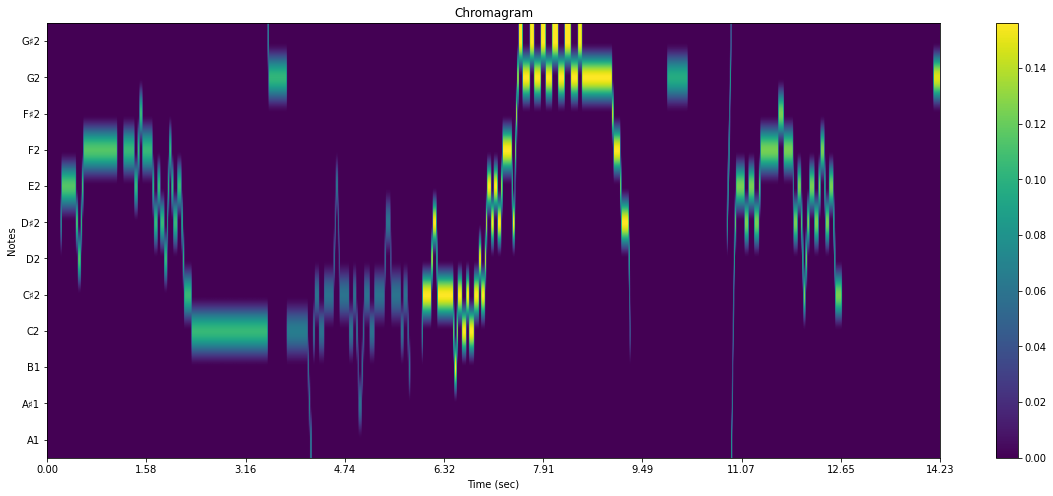

In [200]:
plot_chromagram(chromagram, time, notes)

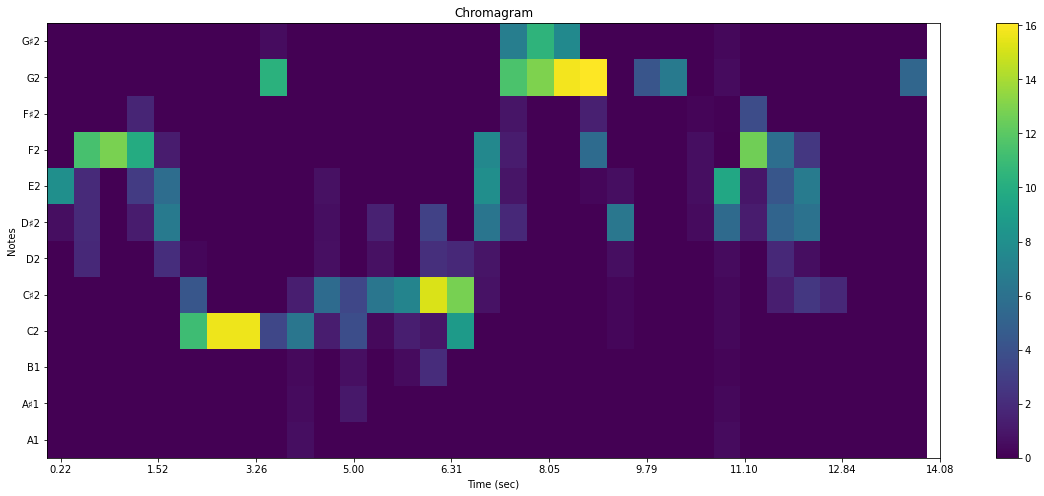

In [201]:
plot_chromagram(chromagram_reduced, time_reduced, notes)